In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
morph_db = alldb.query('W_UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144]
# nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]
# nog102 = []

inout = []
for i in morph_db.index:     
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [3]:
v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

In [5]:
GSD_IR = Table.read(fits.open('/Volumes/Vince_CLEAR/IR_cat/20150520_prior_catalogs_pgh_gs_irac_ch1.cat.fits'), format = 'fits').to_pandas()
GND_IR = Table.read(fits.open('/Volumes/Vince_CLEAR/IR_cat/20150520_prior_catalogs_pgh_gn_irac_ch1.cat.fits'), format = 'fits').to_pandas()

In [10]:
def Match_galaxy(gal_ra, gal_dec, gal_z500, gal_id, cat_ra, cat_dec):

    r = (1. / 60 / 60) * 0.5       

    z500= []
    ids = []
    dr = []

    for i in range(len(cat_ra)):
        cosr = np.sin(np.radians(cat_dec[i])) * np.sin(np.radians(gal_dec)) + np.cos(np.radians(cat_dec[i]))\
                * np.cos(np.radians(gal_dec)) * np.cos(np.radians(cat_ra[i]) - np.radians(gal_ra))
        rad = np.arccos(cosr)
        rad = np.degrees(rad)
       
        z500.append(gal_z500[np.argwhere(rad == min(rad))[0]][0])
        ids.append(gal_id[np.argwhere(rad == min(rad))[0]][0])    
        dr.append(min(rad))
    return z500, ids, dr

In [11]:
SIR_z500, SIR_ids, SIR_dr = Match_galaxy(v4S.ra.values, v4S.dec.values,v4S.z500.values, v4S.id.values, GSD_IR.RA, GSD_IR.DEC)
NIR_z500, NIR_ids, NIR_dr = Match_galaxy(v4N.ra.values, v4N.dec.values,v4N.z500.values, v4N.id.values, GND_IR.RA, GND_IR.DEC)


In [13]:
Sz = []
Sf = []
Si = []
Sr = []
for i in mdb.query('field == "GSD"').index:
    if mdb.id[i] in SIR_ids:
        if np.array(GSD_IR.F24.values)[SIR_ids == mdb.id[i]][0] > 0:
            Sz.append(np.array(SIR_z500)[SIR_ids == mdb.id[i]][0])
            Sf.append(np.array(GSD_IR.F24.values)[SIR_ids == mdb.id[i]][0])
            Si.append(mdb.id[i])
            Sr.append(np.array(SIR_dr)[SIR_ids == mdb.id[i]][0])
Nz = []
Nf = []
Ni = []
Nr = []
for i in mdb.query('field == "GND"').index:
    if mdb.id[i] in NIR_ids:
        if np.array(GND_IR.F24.values)[NIR_ids == mdb.id[i]][0] > 0:
            Nz.append(np.array(NIR_z500)[NIR_ids == mdb.id[i]][0])
            Nf.append(np.array(GND_IR.F24.values)[NIR_ids == mdb.id[i]][0])
            Ni.append(mdb.id[i])
            Nr.append(np.array(NIR_dr)[NIR_ids == mdb.id[i]][0])


(0.5, 2.5)

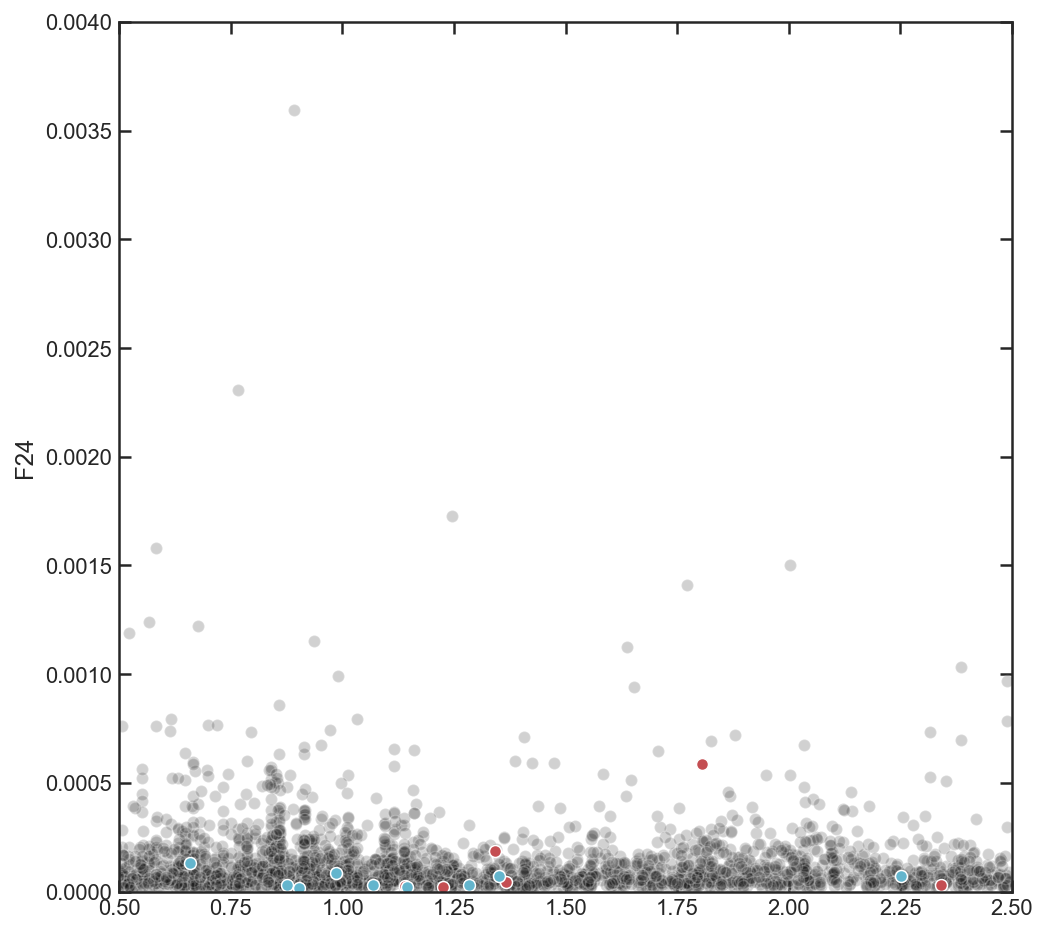

In [146]:
plt.figure(figsize=[8,8])

sea.scatterplot(SIR_z500,GSD_IR.F24, color = 'k', alpha = 0.2)
sea.scatterplot(NIR_z500,GND_IR.F24, color = 'k', alpha = 0.2)

sea.scatterplot(Sz, Sf, color = 'r')
sea.scatterplot(Nz, Nf, color = 'c')
plt.ylim(0,0.004)
plt.xlim(0.5,2.5)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


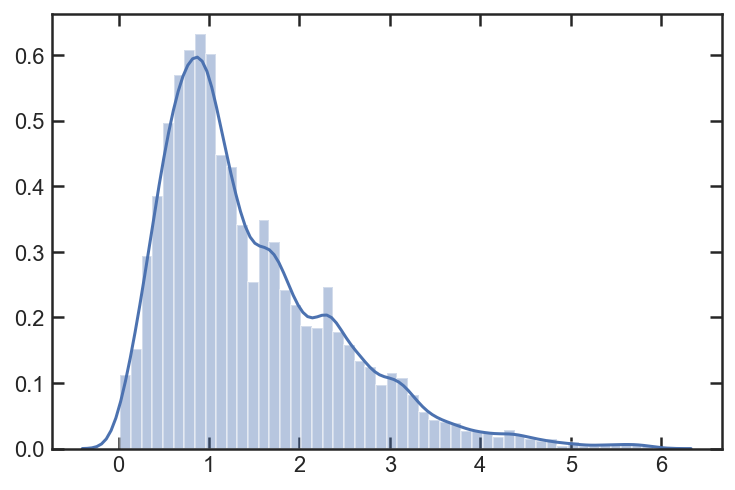

In [143]:
sea.distplot(np.append(np.array(SIR_z500)[np.array(SIR_z500) > 0],np.array(NIR_z500)[np.array(NIR_z500) > 0]))

In [142]:
np.array(SIR_z500)[np.array(SIR_z500) > 0]

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([0.53884102, 2.70767161, 0.24102386, ..., 2.33331873, 1.86450933,
       4.29841231])

# check images

In [265]:
f125 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F125W_orig_sci.fits')
f125_img = f125[0].data
f160 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_orig_sci.fits')
f160_img = f160[0].data

irac1 = fits.open('/Volumes/Vince_CLEAR/IR_img/GOODS-S_SEDS1/GOODS-S_SEDS1_sci_sub.fits')
irac1_img = irac1[0].data
irac2 = fits.open('/Volumes/Vince_CLEAR/IR_img/GOODS-S_SEDS2/GOODS-S_SEDS2_sci_sub.fits')
irac2_img = irac2[0].data
irac3 = fits.open('/Volumes/Vince_CLEAR/IR_img/GOODS-S_irac3/GOODS-S_irac3_s2_sci.fits')
irac3_img = irac3[0].data
irac4 = fits.open('/Volumes/Vince_CLEAR/IR_img/GOODS-S_irac4/GOODS-S_irac4_s2_sci.fits')
irac4_img = irac4[0].data

mips = fits.open('/Volumes/Vince_CLEAR/IR_img/s_mips_1_s1_v0.30_sci.fits')
mips_img = mips[0].data

In [266]:
wf1 = wcs.WCS(f125[0].header)
wf2 = wcs.WCS(f160[0].header)

w1 = wcs.WCS(irac1[0].header)
w2= wcs.WCS(irac2[0].header)
w3= wcs.WCS(irac3[0].header)
w4= wcs.WCS(irac4[0].header)

wm= wcs.WCS(mips[0].header)

In [233]:
wf1.wcs_world2pix([[ra ,dec],[ra+D ,dec-D], [ra-D ,dec+D]],1)

array([[11266.29379943, 16580.51359423],
       [11177.74526865, 16480.52577718],
       [11354.8450451 , 16680.50022507]])

In [235]:
np.array([[11266.29379943, 16580.51359423],
       [11177.74526865, 16480.52577718],
       [11354.8450451 , 16680.50022507]]) - np.array([11177,16480])

array([[ 89.29379943, 100.51359423],
       [  0.74526865,   0.52577718],
       [177.8450451 , 200.50022507]])

In [291]:
(Yf1[1]-Yf1[0])/2,(Xf1[1]-Xf1[0])/2

(88.54988822391533, 99.98722394721335)

In [295]:
D = (6 * u.arcsec * (1*u.arcmin/(60*u.arcsec)) * (1*u.deg/(60*u.arcmin))).value
ra=v4S.query('id == 44042').ra.values[0]
dec=v4S.query('id == 44042').dec.values[0]


################## turn into function#########
[Of1, Lf1, Hf1]=wf1.wcs_world2pix([[ra ,dec],[ra+D ,dec-D], [ra-D ,dec+D]],1)
Of1 -= np.array([int(Lf1[0]),int(Lf1[1])])
Lf1 = Lf1.astype(int)
Hf1 = Hf1.astype(int)
###############################################
[Yf2,Xf2]=np.round(wf2.wcs_world2pix([[ra+D ,dec-D], [ra-D ,dec+D]],1).T).astype(int)

[Y1,X1]=np.round(w1.wcs_world2pix([[ra+D ,dec-D], [ra-D ,dec+D]],1).T).astype(int)
[Y2,X2]=np.round(w2.wcs_world2pix([[ra+D ,dec-D], [ra-D ,dec+D]],1).T).astype(int)
[Y3,X3]=np.round(w3.wcs_world2pix([[ra+D ,dec-D], [ra-D ,dec+D]],1).T).astype(int)
[Y4,X4]=np.round(w4.wcs_world2pix([[ra+D ,dec-D], [ra-D ,dec+D]],1).T).astype(int)

[Ym,Xm]=np.round(wm.wcs_world2pix([[ra+D ,dec-D], [ra-D ,dec+D]],1).T).astype(int)

In [298]:
# gal_imgf1 = f125_img[Xf1[0] :Xf1[1], Yf1[0] :Yf1[1]]
gal_imgf1 = f125_img[Lf1[1] : Hf1[1]+1 , Lf1[0] : Hf1[0]+1]

gal_imgf2 = f160_img[Xf2[0] :Xf2[1], Yf2[0] :Yf2[1]]

gal_img1 = irac1_img[X1[0] :X1[1], Y1[0] :Y1[1]]
gal_img2 = irac2_img[X2[0] :X2[1], Y2[0] :Y2[1]]
gal_img3 = irac3_img[X3[0] :X3[1], Y3[0] :Y3[1]]
gal_img4 = irac4_img[X4[0] :X4[1], Y4[0] :Y4[1]]

gal_imgm = mips_img[Xm[0] :Xm[1], Ym[0] :Ym[1]]

In [280]:
def RS_img(img):
    IMG = np.array(img) + 100

    m = np.percentile(IMG, 5)
    M = np.percentile(IMG, 99)

    IMG -= m
    IMG[IMG <= 0] = 0
    IMG /= (M-m)
    IMG[IMG > 1] =1
#     IMG[IMG**2 > 1]
    return np.arcsinh(IMG)
#     return IMG

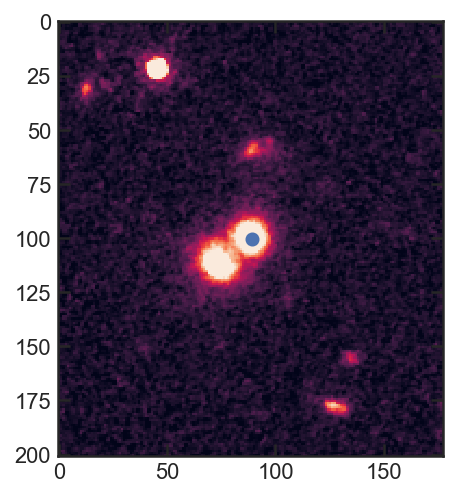

In [301]:
ax1 = plt.subplot()

plt.imshow(RS_img(gal_imgf1))
plt.scatter(Of1[0],Of1[1])

# circle1 = plt.Circle([87,99],10,fill = False, color = 'c', linewidth = 3)
# ax1.add_artist(circle1)

# circle2 = plt.Circle([72,110],10,fill = False, color = 'w', linewidth = 3)
# ax1.add_artist(circle2)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arcsinh
  if sys.path[0] == '':


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/image.py:412: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/image.py:417: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packag

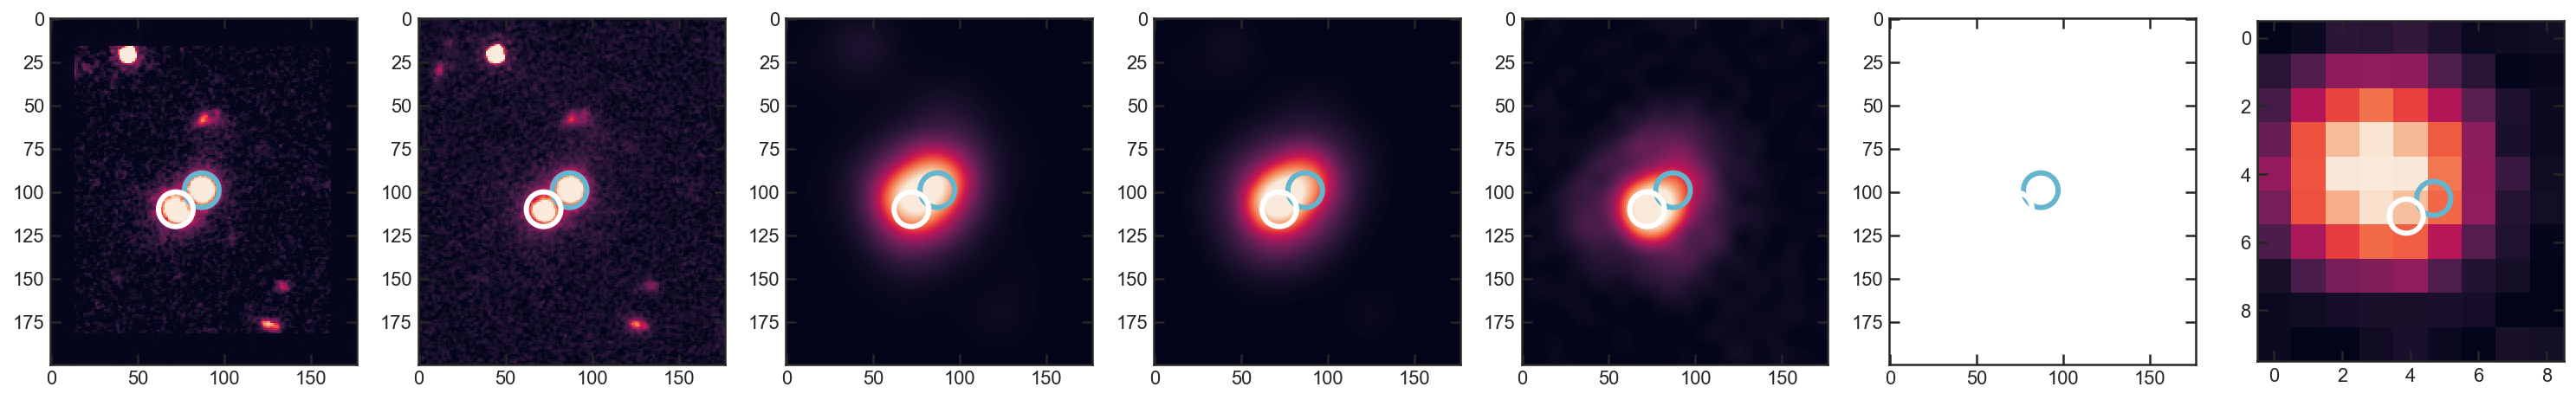

In [230]:
gs = gridspec.GridSpec(1,7)

plt.figure(figsize=[26,12])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
ax5 = plt.subplot(gs[4])
ax6 = plt.subplot(gs[5])
ax7 = plt.subplot(gs[6])




ax1.imshow(RS_img(gal_imgf1))
circle1 = plt.Circle([87,99],10,fill = False, color = 'c', linewidth = 3)
ax1.add_artist(circle1)
circle2 = plt.Circle([72,110],10,fill = False, color = 'w', linewidth = 3)
ax1.add_artist(circle2)

ax2.imshow(RS_img(gal_imgf2))
circle1 = plt.Circle([87,99],10,fill = False, color = 'c', linewidth = 3)
ax2.add_artist(circle1)
circle2 = plt.Circle([72,110],10,fill = False, color = 'w', linewidth = 3)
ax2.add_artist(circle2)

ax3.imshow(RS_img(gal_img1))
circle1 = plt.Circle([87,99],10,fill = False, color = 'c', linewidth = 3)
ax3.add_artist(circle1)
circle2 = plt.Circle([72,110],10,fill = False, color = 'w', linewidth = 3)
ax3.add_artist(circle2)

ax4.imshow(RS_img(gal_img2))
circle1 = plt.Circle([87,99],10,fill = False, color = 'c', linewidth = 3)
ax4.add_artist(circle1)
circle2 = plt.Circle([72,110],10,fill = False, color = 'w', linewidth = 3)
ax4.add_artist(circle2)

ax5.imshow(RS_img(gal_img3))
circle1 = plt.Circle([87,99],10,fill = False, color = 'c', linewidth = 3)
ax5.add_artist(circle1)
circle2 = plt.Circle([72,110],10,fill = False, color = 'w', linewidth = 3)
ax5.add_artist(circle2)

ax6.imshow(RS_img(gal_img4))
circle1 = plt.Circle([87,99],10,fill = False, color = 'c', linewidth = 3)
ax6.add_artist(circle1)
circle2 = plt.Circle([72,110],10,fill = False, color = 'w', linewidth = 3)
ax6.add_artist(circle2)

ax7.imshow(RS_img(gal_imgm))
circle1 = plt.Circle([87 * 9/167,99*7/147],0.5,fill = False, color = 'c', linewidth = 3)
ax7.add_artist(circle1)
circle2 = plt.Circle([72 * 9/167,110*7/147],0.5,fill = False, color = 'w', linewidth = 3)
ax7.add_artist(circle2)

In [175]:
Xm[1]-Xm[0], Ym[1]-Ym[0]

(9, 7)

In [176]:
Xf1[1] - Xf1[0], Yf1[1] - Yf1[0]

(167, 147)

In [214]:
9/167,7/147

(0.05389221556886228, 0.047619047619047616)

In [228]:
Ym, Xm

(array([599, 608]), array([895, 905]))

In [229]:
Y1, X1

(array([11178, 11355]), array([16481, 16681]))